# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import math

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [5]:
df = pd.read_csv('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [8]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [10]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3300,1,36.0,40000.0,0,0
4998,1,22.0,32700.0,3,0
178,1,35.0,37300.0,1,0
4484,1,42.0,23700.0,3,0
153,0,20.0,35200.0,1,0
1842,0,44.0,28000.0,0,1
3249,1,32.0,42400.0,3,0
1381,0,40.0,18300.0,0,0
861,0,39.0,29600.0,1,0
3703,1,33.0,41100.0,1,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [14]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype(int)

In [16]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [18]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [20]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [22]:
# check for Missing Values
df.isnull().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [24]:
# check for duplicates
df.duplicated().sum()

153

In [26]:
# dropping duplicate rows
df.drop_duplicates(inplace=True, ignore_index=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int32  
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 170.5 KB


Everything in our descriptive statistics looks ok. There are no missing rows. I dealt with duplicate rows by dropping them from the dataframe since the duplicate rows only represented about 3% of the total data. From the mean gender we can tell that there are slightly more males (0) and fewer females in our dataset. 

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

C:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


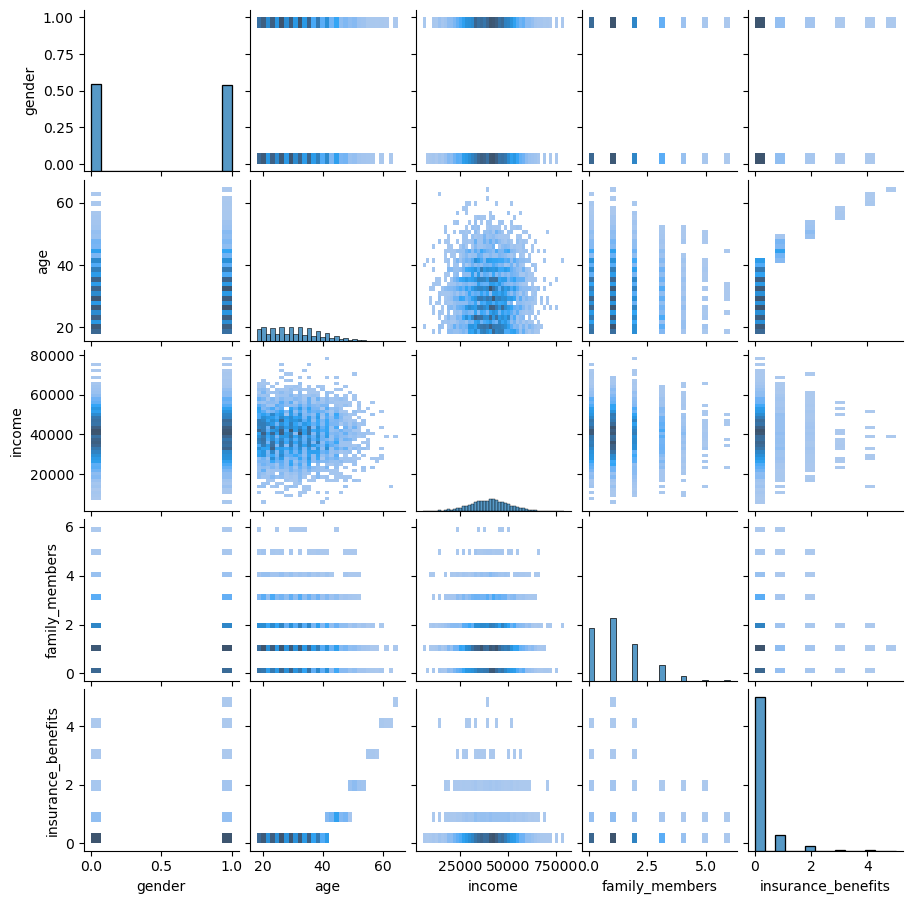

In [34]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(9, 9)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [36]:
#Checking for correlation between features
corr = df.corr()
corr

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.001953,0.015456,-0.007315,0.011565
age,0.001953,1.000000,-0.017386,-0.009064,0.654964
income,0.015456,-0.017386,1.000000,-0.031687,-0.013123
family_members,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
insurance_benefits,0.011565,0.654964,-0.013123,-0.039303,1.000000


In [38]:
# checking for value counts
for i in df:
    print(df[i].value_counts())
    print()

gender
0    2431
1    2416
Name: count, dtype: int64

age
19    213
25    205
31    202
26    201
22    201
27    201
29    196
28    196
30    196
32    196
23    195
21    193
20    190
36    186
33    186
24    176
34    173
35    173
37    143
39    140
38    135
41    124
18    116
40    110
42     93
43     77
44     74
45     73
46     60
47     47
49     37
50     26
48     26
52     22
51     21
53     11
55      9
54      7
56      5
59      3
57      2
58      2
60      2
61      1
65      1
62      1
Name: count, dtype: int64

income
45800.0    28
37100.0    27
38800.0    26
32800.0    26
40500.0    25
           ..
17700.0     1
70600.0     1
18100.0     1
13000.0     1
56800.0     1
Name: count, Length: 524, dtype: int64

family_members
1    1748
0    1461
2    1038
3     437
4     124
5      32
6       7
Name: count, dtype: int64

insurance_benefits
0    4284
1     423
2     114
3      18
4       7
5       1
Name: count, dtype: int64



# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [43]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [45]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(df[feature_names].to_numpy())
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [48]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [50]:
df_scaled.sample(30)

,gender,age,income,family_members,insurance_benefits
779,0,0.615385,0.503797,0.166667,0
3043,1,0.600000,0.596203,0.166667,0
285,0,0.600000,0.455696,0.000000,0
1360,0,0.323077,0.554430,0.500000,0
703,1,0.615385,0.486076,0.166667,0
4212,0,0.353846,0.460759,0.500000,0
4435,1,0.415385,0.549367,0.166667,0
3041,0,0.384615,0.697468,0.333333,0
1621,1,0.615385,0.525316,0.166667,0
1627,0,0.707692,0.532911,0.333333,1


Now, let's get similar records for a given one for every combination

In [52]:
df.iloc[1368, :]

gender                    1.0
age                      35.0
income                41000.0
family_members            0.0
insurance_benefits        0.0
Name: 1368, dtype: float64

In [54]:
# unscaled data
get_knn(df, n=5, k=11, metric="euclidean") #euclidean distance

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1965,0,45,41000.0,0,1,3.000000
3860,1,40,41000.0,1,0,3.162278
3695,0,46,41000.0,2,1,3.162278
4617,1,46,41000.0,1,1,3.162278
2700,0,47,41000.0,3,1,4.242641
2659,0,37,41000.0,0,0,6.403124
3344,1,36,41000.0,2,0,7.000000
1716,0,36,41000.0,1,0,7.141428
2812,0,35,41000.0,2,0,8.062258


In [56]:
get_knn(df, n=5, k=11, metric="manhattan") #manhattan distance

,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1965,0,45,41000.0,0,1,3.000000
3860,1,40,41000.0,1,0,3.162278
3695,0,46,41000.0,2,1,3.162278
4617,1,46,41000.0,1,1,3.162278
2700,0,47,41000.0,3,1,4.242641
2659,0,37,41000.0,0,0,6.403124
3344,1,36,41000.0,2,0,7.000000
1716,0,36,41000.0,1,0,7.141428
2812,0,35,41000.0,2,0,8.062258


In [58]:
# scaled data
get_knn(df_scaled, n=5, k=11, metric="euclidean") #euclidean distance

,gender,age,income,family_members,insurance_benefits,distance
5,1,0.661538,0.518987,0.333333,1,0.000000
1136,1,0.646154,0.516456,0.333333,0,0.015592
3955,1,0.661538,0.501266,0.333333,1,0.017722
1011,1,0.646154,0.501266,0.333333,0,0.023468
2897,1,0.630769,0.520253,0.333333,0,0.030795
2097,1,0.692308,0.512658,0.333333,1,0.031413
106,1,0.692308,0.526582,0.333333,1,0.031693
2172,1,0.692308,0.530380,0.333333,1,0.032811
2314,1,0.692308,0.531646,0.333333,1,0.033271
715,1,0.630769,0.532911,0.333333,0,0.033773


In [60]:
get_knn(df_scaled, n=5, k=11, metric="manhattan") #manhattan distance

,gender,age,income,family_members,insurance_benefits,distance
5,1,0.661538,0.518987,0.333333,1,0.000000
1136,1,0.646154,0.516456,0.333333,0,0.015592
3955,1,0.661538,0.501266,0.333333,1,0.017722
1011,1,0.646154,0.501266,0.333333,0,0.023468
2897,1,0.630769,0.520253,0.333333,0,0.030795
2097,1,0.692308,0.512658,0.333333,1,0.031413
106,1,0.692308,0.526582,0.333333,1,0.031693
2172,1,0.692308,0.530380,0.333333,1,0.032811
2314,1,0.692308,0.531646,0.333333,1,0.033271
715,1,0.630769,0.532911,0.333333,0,0.033773


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Whether the data is scaled or not will have a large affect of the kNN algorithm. The distances that are calculated as the metric portion of the algorithm will be much different if the data is not scaled. For example, certain features will have larger scales than others, and depending on the size of those differences, the algorithm will treat all the distances the same thereby causing a skewed or weighted output. 

Scaling the data will account for different sizes of distributions and scales amongst features, leading to a more balanced model.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The Manhattan distance results are similar regardless of the scaling. The differences differ ever so slightly.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [68]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'] > 0

In [70]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

insurance_benefits_received
False    4284
True      563
Name: count, dtype: int64

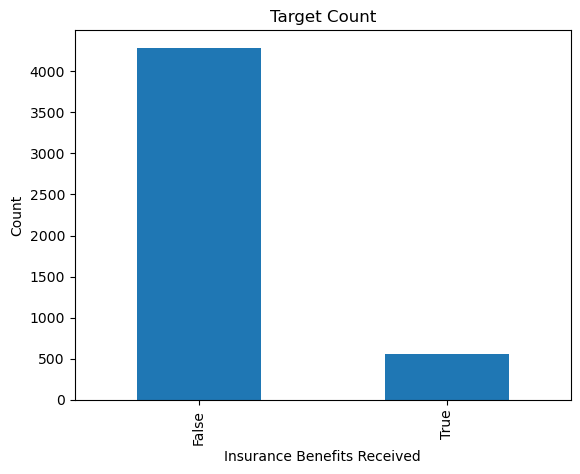

In [72]:
# plotting Class imbalances

df['insurance_benefits_received'].value_counts().plot(kind='bar', title='Target Count')
plt.xlabel('Insurance Benefits Received')
plt.ylabel('Count')
plt.show()

In [74]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [76]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [78]:
# random dummy model on 4 different probabilities values

for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df['insurance_benefits_received']), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



In [80]:
# original Dataset
X = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
y = df['insurance_benefits_received']

# train, Test, Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [82]:
# scaled Dataset
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(X_train.to_numpy())

def max_abs_scaler(data):
    data_scaled = data.copy()
    data_scaled.loc[:, :] = transformer_mas.transform(data.to_numpy())
    return data_scaled
X_train_scaled = max_abs_scaler(X_train)
X_test_scaled = max_abs_scaler(X_test)


In [84]:
# training the KNN model
def knn_function (X_train, y_train, X_test):
    for i in range (1, 11):
        print("k = ", i)
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        eval_classifier(y_test, y_pred)
        print('')

In [86]:
# evaluating the model on unscaled data

knn_function(X_train, y_train, X_test)

k =  1
F1: 0.67
Confusion Matrix
[[0.86323024 0.02130584]
 [0.04604811 0.06941581]]

k =  2
F1: 0.38
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.08728522 0.02817869]]

k =  3
F1: 0.38
Confusion Matrix
[[0.87079038 0.0137457 ]
 [0.08522337 0.03024055]]

k =  4
F1: 0.18
Confusion Matrix
[[0.8790378  0.00549828]
 [0.10378007 0.01168385]]

k =  5
F1: 0.23
Confusion Matrix
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]

k =  6
F1: 0.06
Confusion Matrix
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]

k =  7
F1: 0.07
Confusion Matrix
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]

k =  8
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]

k =  9
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]

k =  10
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]



In [88]:
#Evaluating the model on scaled data

knn_function(X_train_scaled, y_train, X_test_scaled)

k =  1
F1: 0.92
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01237113 0.10309278]]

k =  2
F1: 0.89
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02199313 0.09347079]]

k =  3
F1: 0.90
Confusion Matrix
[[0.88041237 0.00412371]
 [0.01786942 0.0975945 ]]

k =  4
F1: 0.87
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02474227 0.09072165]]

k =  5
F1: 0.90
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01786942 0.0975945 ]]

k =  6
F1: 0.85
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02749141 0.08797251]]

k =  7
F1: 0.89
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02061856 0.09484536]]

k =  8
F1: 0.86
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02680412 0.08865979]]

k =  9
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]

k =  10
F1: 0.85
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02749141 0.08797251]]



**Conclusion**

For the unscaled data, the F1 score decreases as K increases, with a max F1 score of 0.67. On scaled data, we see a maximum F1 score of .92 occuring at K=1. These F1 scores gradually decrease as K increases.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [95]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights)
        
        return y_pred

In [97]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [99]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 2.28587827e-02 -3.57052853e-02 -1.13606227e-05 -4.73354538e-02]
RMSE: 0.39
R2: 0.57


In [101]:
# scaled data
lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)


[-0.03570529  1.48582087 -0.84977458 -0.28401272]
RMSE: 0.39
R2: 0.57


**Conclusion**

Performing linear regression on the both the scaled and unscaled datasets yielded similar results. Despite having different weights, the RMSE of 0.39 and the R2 of 0.57 were the same. Hence, scaling the data will not have an outsized effect on the results of a LR model.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [106]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [108]:
X = df_pn.to_numpy()

X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generating a random matrix $P$.

In [111]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [114]:
try:
    inverse_of_P = np.linalg.inv(P)
    print("The matrix P is invertible")
except: 
    np.linalg.LinAlgError 
    print("The matrix P is not invertible")

The matrix P is invertible


Can you guess the customers' ages or income after the transformation?

In [117]:
X_obfuscated = X @ P

X_obfuscated

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

The customers' ages or income cannot be guessed after the transformation.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [121]:
X_unobfuscated = X_obfuscated @ inverse_of_P

X_unobfuscated

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-3.63797881e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [ 1.81898940e-12,  2.90000000e+01,  2.10000000e+04,
         0.00000000e+00],
       ...,
       [ 0.00000000e+00,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [124]:
print('The original data:')
display(pd.DataFrame(X, columns=personal_info_column_list).head(3))
print('')
print('The transformed one:')
display(pd.DataFrame(X_obfuscated, columns=personal_info_column_list).head(3))
print('')
print('The reversed (recovered) one:')
display(pd.DataFrame(X_unobfuscated, columns=personal_info_column_list).head(3))

The original data:


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0



The transformed one:


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631



The reversed (recovered) one:


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.0
1,-3.637979e-12,46.0,38000.0,1.0
2,1.818989e-12,29.0,21000.0,0.0


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Floats are calculated down to x decimal places when the matrices are transformed. This causes very small numbers not to be written as 0.0.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

Original model's predictions: $$\hat{y} = Xw$$

Model with obfuscated data: $$\hat{y}_{p} = X^pw_{p} = XPP^-1 w = Xw = \hat{y}$$

The predicted values with $w_P$ would not change, therefore RMSE would not change, thereby preserving the quality of linear regression. 

**Analytical proof**

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

$$
w_P = [P^TX^TXP]^{-1}P^TX^Ty
$$

$$
w_P = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$

$$
w_P = P^{-1}(X^TX)^{-1}X^Ty
$$

$$
w_P = P^{-1}w
$$


## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [138]:
# creating a square matrix P of random numbers

rng = np.random.default_rng(seed=41)
P = rng.random(size=(X.shape[1], X.shape[1]))

P

array([[0.9541511 , 0.76793209, 0.12597075, 0.82698809],
       [0.84907207, 0.34978284, 0.51140923, 0.60249991],
       [0.33883591, 0.6218064 , 0.73248467, 0.86108828],
       [0.33782439, 0.42928924, 0.59418134, 0.97567793]])

In [140]:
# checking square matrix P for invertibility

try:
    inverse_of_P = np.linalg.inv(P)
    print("The matrix P is invertible")
except: 
    np.linalg.LinAlgError 
    print("The matrix P is not invertible")

The matrix P is invertible


In [142]:
df

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,False
1,0,46,38000.0,1,1,True
2,0,29,21000.0,0,0,False
3,0,21,41700.0,2,0,False
4,1,28,26100.0,0,0,False
...,...,...,...,...,...,...
4842,0,28,35700.0,2,0,False
4843,0,34,52400.0,1,0,False
4844,0,20,33900.0,2,0,False
4845,1,22,32700.0,3,0,False


In [144]:
# initializing linear regression model
# unscaled data

X = df.drop(df[['insurance_benefits', 'insurance_benefits_received']], axis=1).to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345) # splitting the data

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)


[-3.57052853e-02  2.28587827e-02 -1.13606227e-05 -4.73354538e-02]
RMSE: 0.39
R2: 0.57


In [146]:
# scaled data

lr_scaled = MyLinearRegression()

lr_scaled.fit(X_train_scaled, y_train)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

[-0.03570529  1.48582087 -0.84977458 -0.28401272]
RMSE: 0.39
R2: 0.57


# Conclusions

- Scaling data can have an outsized impact on metrics. 
- KNN distances can be strongly affected by unscaled data. The more spread out the features may be, KNN distances will be larger and larger. 
- Scaled data lead to higher F1 scores in the KNN model. 
- Data obfuscating does not affect RMSE metrics
- Obfuscated data can be recovered with the transformation matrix.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [X]  Code is error free
- [X]  The cells are arranged in order of logic and execution
- [X]  Task 1 has been performed
    - [X]  There is the procedure that can return k similar customers for a given one
    - [X]  The procedure is tested for all four proposed combinations
    - [X]  The questions re the scaling/distances are answered
- [X]  Task 2 has been performed
    - [X]  The random classification model is built and tested for all for probability levels
    - [X]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [X]  Task 3 has been performed
    - [X]  The linear regression solution is implemented with matrix operations.
    - [X]  RMSE is calculated for the implemented solution.
- [X]  Task 4 has been performed
    - X ]  The data is obfuscated with a random and invertible matrix P
    - [X]  The obfuscated data is recoved, few examples are printed out
    - [X]  The analytical proof that the transformation does not affect RMSE is provided 
    - [X]  The computational proof that the transformation does not affect RMSE is provided
- [X]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>